In [1]:
from utils import featurize_lc, defeaturize_lc
from IPython.display import display
from ipywidgets import Button
import numpy as np
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import torch
print(torch.__version__)
import gzip
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
import pickle
import numpy as np
from VAE import VAE



1.5.1


## Dataset

In [2]:
with gzip.open("../data/lc_data.pgz", mode="r") as f:
    lc_data = pickle.load(f)
    
lc_periods = pickle.load(open("../data/lc_periods.pkl", "rb"))

phi_interp = np.linspace(0, 1, num=40)
features = np.zeros(shape=(len(lc_data), len(phi_interp)))
weights = np.zeros(shape=(len(lc_data), len(phi_interp)))
norm = np.zeros(shape=(len(lc_data), 3))
for i in range(len(lc_data)):
    features[i, :], weights[i, :], norm[i, :] = featurize_lc(lc_data[i], lc_periods[i], phi_interp)
    



lc_dataset = TensorDataset(torch.from_numpy(features.astype('float32')), 
                           torch.from_numpy(weights.astype('float32')),
                           torch.from_numpy(lc_periods.astype('float32')))



#np.random.seed(1234) 
# Generate data loaders
P = np.random.permutation(5000)
train_loader = DataLoader(dataset=lc_dataset, batch_size=128, 
                          sampler=SubsetRandomSampler(P[:4000]))
valid_loader = DataLoader(dataset=lc_dataset, batch_size=128, 
                          sampler=SubsetRandomSampler(P[4000:]))

## Entrenamiento

VAE(
  (enc1): Conv1d(1, 3, kernel_size=(4,), stride=(2,), padding=(1,))
  (enc2): Conv1d(3, 6, kernel_size=(4,), stride=(2,), padding=(3,))
  (enc3): Conv1d(6, 12, kernel_size=(4,), stride=(2,), padding=(1,))
  (enc4): Linear(in_features=73, out_features=128, bias=True)
  (enc5): Linear(in_features=128, out_features=64, bias=True)
  (enc_mu): Linear(in_features=64, out_features=2, bias=True)
  (enc_logstd): Linear(in_features=64, out_features=2, bias=True)
  (dec1): Linear(in_features=2, out_features=64, bias=True)
  (dec2): Linear(in_features=64, out_features=128, bias=True)
  (dec3): Linear(in_features=128, out_features=73, bias=True)
  (dec4): ConvTranspose1d(3, 1, kernel_size=(4,), stride=(2,), padding=(1,))
  (dec5): ConvTranspose1d(6, 3, kernel_size=(4,), stride=(2,), padding=(3,))
  (dec6): ConvTranspose1d(12, 6, kernel_size=(4,), stride=(2,), padding=(1,))
  (activation): ReLU()
)


<IPython.core.display.Javascript object>


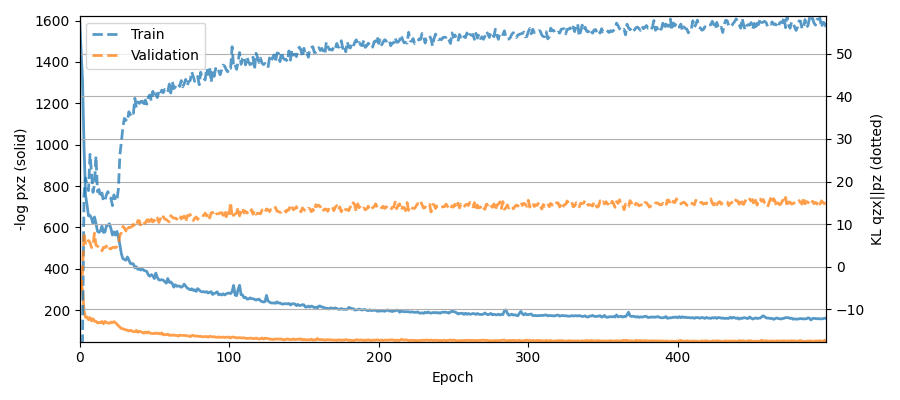

/home/admin/miniconda3/envs/PT/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Se encontró un mejor modelo:  84.9752926826477 93.9706180691719
Se encontró un mejor modelo:  74.25866985321045 82.30379235744476
Se encontró un mejor modelo:  62.07937717437744 73.0091378390789
Se encontró un mejor modelo:  41.79629993438721 54.94494143128395
Se encontró un mejor modelo:  36.73151445388794 44.097833424806595
Se encontró un mejor modelo:  35.01693511009216 41.16224992275238
Se encontró un mejor modelo:  33.678534269332886 39.626232266426086
Se encontró un mejor modelo:  32.43885040283203 38.39430984854698
Se encontró un mejor modelo:  31.13189172744751 36.661746978759766
Se encontró un mejor modelo:  30.70653748512268 35.40239170193672
Se encontró un mejor modelo:  30.473536014556885 34.836581975221634
Se encontró un mejor modelo:  30.083006381988525 34.331279784440994
Se encontró un mejor modelo:  29.75162434577942 34.87545624375343
Se encontró un mejor modelo:  29.658596992492676 34.74079945683479
Se encontró un mejor modelo:  29.51509952545166 34.69961059093475
Se e

In [32]:
n_epoch=500
from tqdm import tqdm_notebook
from utils import live_metric_plotter

# instantiate model
model=VAE().cuda()
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
den = train_loader.__len__()*train_loader.batch_size
den_val = valid_loader.__len__()*valid_loader.batch_size
global_loss=np.inf
plotter = live_metric_plotter(figsize=(9, 4))
metrics = np.zeros(shape=(n_epoch, 2, 2))
for epoch in tqdm_notebook(range(n_epoch)):
    train_loss=0.0
    Rec_loss=0.0
    KL_loss=0.0
    for data in train_loader:
        optimizer.zero_grad()  
        star=data[0].cuda()
        weight=data[1].cuda()
        period=data[2].cuda()
        loss2,rec,KL=model.supremo_elbo(star,weight,period,samples=1)
        #print(weight)
        loss=rec+KL
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        Rec_loss += rec.item()
        KL_loss += KL.item()
        metrics[epoch, 0, 0] += Rec_loss/len(train_loader.sampler)
        metrics[epoch, 0, 1] += KL_loss/len(train_loader.sampler)
    #print(train_loss)
    valid_loss=0.0
    Rec_loss=0.0
    KL_loss=0.0
    for data in valid_loader:
        star=data[0].cuda()
        weight=data[1].cuda()
        period=data[2].cuda()
        loss2,rec,KL=model.supremo_elbo(star,weight,period,samples=1)
        loss=rec+KL
        valid_loss += loss.item()
        Rec_loss += rec.item()
        KL_loss += KL.item()
        metrics[epoch, 1, 0] += Rec_loss/len(valid_loader.sampler)
        metrics[epoch, 1, 1] += KL_loss/len(valid_loader.sampler)
    if valid_loss<global_loss:
        global_loss=valid_loss
        print("Se encontró un mejor modelo: ",Rec_loss/den_val, train_loss/den)
        torch.save(model.state_dict(), '/opt/data-nas/Models_Javier/VAE_astro.pt')
    if epoch > 0:
        plotter.update(epoch, metrics)
        
        

## Cargar mejor modelo

In [3]:
model=VAE()
model.load_state_dict(torch.load("/opt/data-nas/Models_Javier/VAE_astro.pt"))

<All keys matched successfully>

## Plotear resultados

<IPython.core.display.Javascript object>


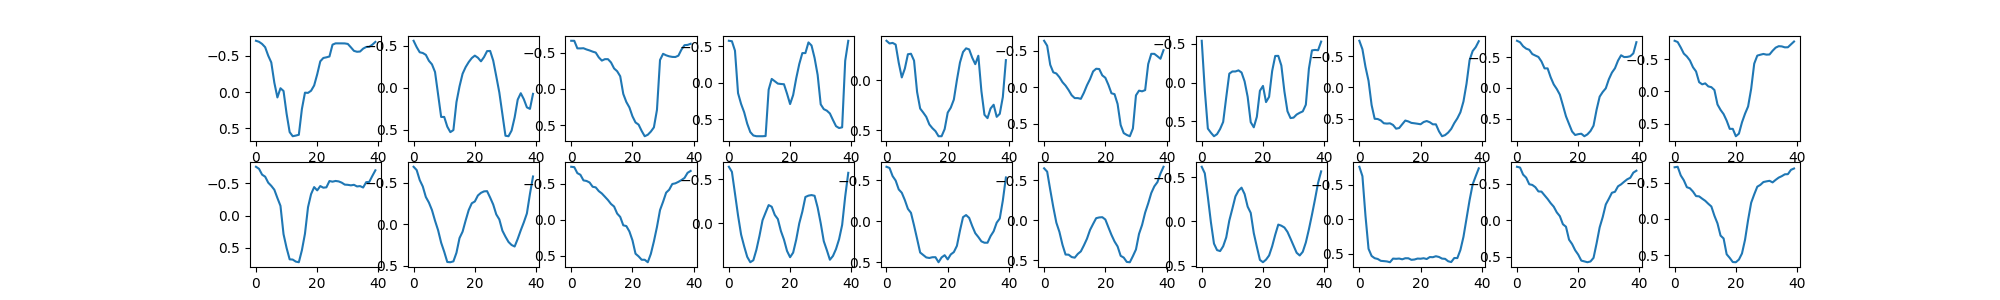

In [4]:
fig, axs = plt.subplots(2, 10, figsize=(20, 3))
P = np.random.permutation(5000)

for i in range(10):
    feature, error, frec = lc_dataset[P[i]]
   # print(feature.shape)
    enc_mu,enc_logvar,dec_mu= model.forward(feature.unsqueeze(0),1,frec.unsqueeze(0))
    axs[0][i].invert_yaxis()
    
    axs[0][i].plot(feature)
    axs[1][i].invert_yaxis()
    axs[1][i].plot(dec_mu[0].detach().numpy())

## Observando el espacio latente

## Scatterplot interactivo

<IPython.core.display.Javascript object>


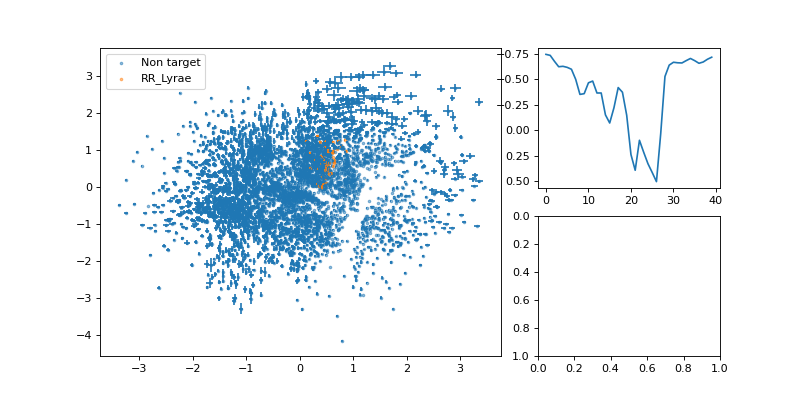

In [8]:
fig = plt.figure(figsize=(10, 5), dpi=80)
ax_main = plt.subplot2grid((2, 3), (0, 0), colspan=2, rowspan=2)
ax_ori = plt.subplot2grid((2, 3), (0, 2))
ax_rec = plt.subplot2grid((2, 3), (1, 2))
ax_ori.axis('off'); ax_rec.axis('off');



N =  lc_dataset.__len__()
test_targets =np.array( [ 0 if x<4950 else 1 for x in range(5000)])#np.array( [ 0 if x<10 else 1 for x in range(15)])  #mnist_test_data.targets.numpy()
code_targets = []
code_error=[]

for x, y ,w in lc_dataset:

    enc_mu,enc_logstd = model.encode(x.unsqueeze(0),w.unsqueeze(0))
    code_targets.append(enc_mu)
    code_error.append(enc_logstd.exp())
    #print(enc_logstd.exp())
   # print(enc_logvar.exp().)
    

#code targets=code_targets[0:100,:]
code_targets = torch.cat(code_targets).detach().numpy()
#code_targets=code_targets[4940:4955,:]
#code_targets=code_targets.squeeze(1)
code_error = torch.cat(code_error).detach().numpy()
#code_error=code_error[4940:4955,:]


for digit in range(2):
    ax_main.scatter(code_targets[test_targets == digit, 0], 
                    code_targets[test_targets == digit, 1], 
                    s=5, alpha=0.5, label="RR_Lyrae" if digit==1 else "Non target")
    ax_main.errorbar(code_targets[test_targets == digit, 0], 
                    code_targets[test_targets == digit, 1],
                    xerr=code_error[test_targets == digit,0],
                    yerr=code_error[test_targets == digit,1], linestyle="None")
ax_main.legend();

def onclick(event):
    ax_rec.cla()  
    ax_ori.cla() 
    ax_rec.invert_yaxis()
    ax_ori.invert_yaxis()
    code_closest = [event.xdata, event.ydata]
    idx = np.argmin(np.sum((code_targets - code_closest)**2, axis=1))
    #star, w, period = lc_dataset[idx]
    #enc_mu,enc_logvar,dec_mu = model.forward(star.unsqueeze(0),1,period.unsqueeze(0))
    ax_ori.plot(lc_dataset[idx][0].numpy())
    #ax_rec.plot(dec_mu[0].detach().numpy())

   
   
    
cid = fig.canvas.mpl_connect('button_press_event', onclick)

## Espacio interpolado

<IPython.core.display.Javascript object>


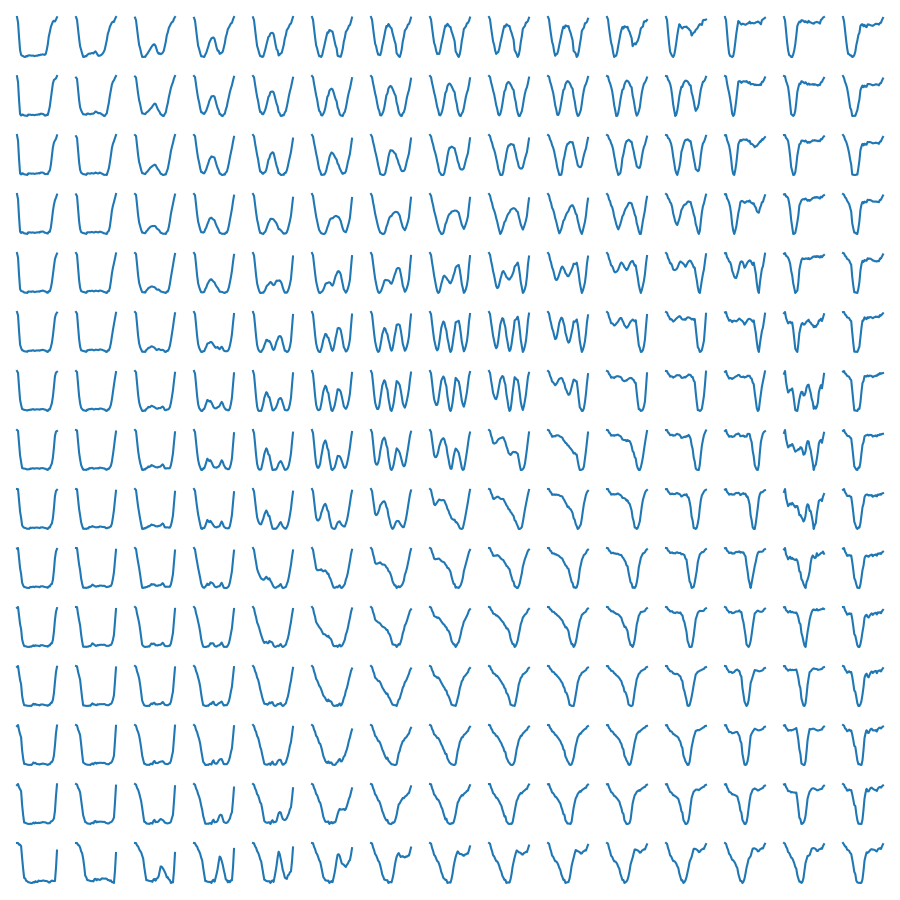

In [36]:
import scipy.stats

n = 15 # figure with 15x15 digits
digit_size = 4
z1 = scipy.stats.norm.ppf(np.linspace(0.01, 0.99, n))
z2 = scipy.stats.norm.ppf(np.linspace(0.01, 0.99, n))
z_grid =torch.tensor(np.dstack(np.meshgrid(z1, z2)),dtype=torch.float32)
#ex=model.decode(z_grid[0][0],1)

   
#print(z_grid)
ex2=model.decode(z_grid,1)


ex2=ex2.view(15,15,-1)
#print(ex2.shape)

ex2=ex2.detach().numpy()

fig,ax=plt.subplots(15, 15, figsize=(9, 9), tight_layout=True)
for i in range(0,15):
    for j in range(0,15):
        img = ex2[i][j]
        ax[i][j].plot(img)
        ax[i][j].invert_yaxis()
        ax[i][j].axis("off")
        

<IPython.core.display.Javascript object>


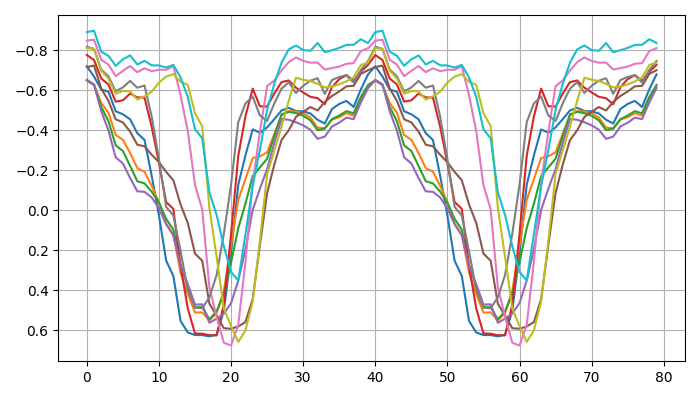

In [47]:
fig,ax=plt.subplots(1, 1, figsize=(7, 4), tight_layout=True)
#ax.set_xticks(np.arange(0,1.6,0.02))
ax.plot(np.concatenate((ex2[14][14],ex2[14][14])))
ax.plot(np.concatenate((ex2[14][13],ex2[14][13])))
ax.plot(np.concatenate((ex2[14][12],ex2[14][12])))
ax.plot(np.concatenate((ex2[13][14],ex2[13][14])))
ax.plot(np.concatenate((ex2[14][10],ex2[14][10])))
ax.plot(np.concatenate((ex2[13][10],ex2[13][10])))
ax.plot(np.concatenate((ex2[11][13],ex2[11][13])))
ax.plot(np.concatenate((ex2[11][14],ex2[11][14])))
ax.plot(np.concatenate((ex2[11][12],ex2[11][12])))
ax.plot(np.concatenate((ex2[10][13],ex2[10][13])))
plt.grid()


ax.invert_yaxis()

In [15]:
len(np.arange(0,1.6,0.02))

80

In [16]:
ex2[13][1]

array([-0.7030807 , -0.7577158 , -0.7447871 , -0.69379306, -0.6183397 ,
       -0.59362364, -0.58665335, -0.46430132, -0.40489432,  0.02715611,
        0.1350345 ,  0.52868754,  0.581901  ,  0.70842737,  0.62218124,
        0.4158842 ,  0.3378299 , -0.03609622, -0.14820808, -0.5008906 ,
       -0.53973883, -0.6193773 , -0.63274443, -0.6459374 , -0.65469635,
       -0.68017024, -0.6873697 , -0.6946142 , -0.69124734, -0.6370444 ,
       -0.6302099 , -0.603506  , -0.60796446, -0.6517913 , -0.6563085 ,
       -0.66754025, -0.6496795 , -0.71223825, -0.71543664, -0.77311444],
      dtype=float32)